In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# 얼굴 인식

copy from : https://github.com/santhalakshminarayana/face-recognition/blob/master/Face_Recognition.ipynb

아티클 : https://medium.com/analytics-vidhya/face-recognition-with-vgg-face-in-keras-96e6bc1951d5


# 데이터 준비

In [107]:
%cd /content

/content


In [111]:
!rm -rf __MACOSX
!rm -rf face_data.zip
!rm -rf face_data

In [112]:
!wget https://github.com/dhrim/hongik_2020/raw/master/material/deep_learning/face_data.zip

--2020-06-22 11:14:50--  https://github.com/dhrim/hongik_2020/raw/master/material/deep_learning/face_data.zip
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dhrim/hongik_2020/master/material/deep_learning/face_data.zip [following]
--2020-06-22 11:14:50--  https://raw.githubusercontent.com/dhrim/hongik_2020/master/material/deep_learning/face_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 917244 (896K) [application/zip]
Saving to: ‘face_data.zip’

face_data.zip       100%[===================>] 895.75K  --.-KB/s    in 0.04s   

2020-06-22 11:14:51 (23.6 MB/s) - ‘face_data.zip’ saved [917244/9

In [113]:
!unzip face_data.zip

Archive:  face_data.zip
   creating: face_data/
   creating: face_data/Images/
  inflating: face_data/Images/faker_1.jpg  
  inflating: face_data/Images/faker_10.jpg  
  inflating: face_data/Images/faker_11.jpg  
  inflating: face_data/Images/faker_15.jpg  
  inflating: face_data/Images/faker_16.jpg  
  inflating: face_data/Images/faker_18.jpg  
  inflating: face_data/Images/faker_2.jpg  
  inflating: face_data/Images/faker_21.jpg  
  inflating: face_data/Images/faker_22.jpg  
  inflating: face_data/Images/faker_23.jpg  
  inflating: face_data/Images/faker_24.jpg  
  inflating: face_data/Images/faker_3.jpg  
  inflating: face_data/Images/faker_7.jpg  
  inflating: face_data/Images/faker_8.jpg  
  inflating: face_data/Images/faker_9.jpg  
  inflating: face_data/Images/iu_10.jpg  
  inflating: face_data/Images/iu_11.jpg  
  inflating: face_data/Images/iu_12.jpg  
  inflating: face_data/Images/iu_13.jpg  
  inflating: face_data/Images/iu_14.jpg  
  inflating: face_data/Images/iu_15.jpg  


## 데이터 준비

아래와 같이 데이터를 준비한다.

```
face_data/
  Images/
    jobs_1.jpg
    jobs_2.jpg
    ...
    faker_1.jpg
    faker_2.jpg
    ...
    iu_1.jpg
    iu_2.jpg
  Test_images/
    jobs_11.jpg
    jobs_12.jpg
    ...
    faker_11.jpg
    faker_12.jpg
    ...
    iu_11.jpg
    iu_12.jpg
```



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [116]:
path='/content/face_data'

In [119]:
%cd $path

/content/face_data


In [120]:
import os
import glob

In [121]:
# Get Image names stored in "Images" folder
image_path_names=[]
person_names=set()
for file_name in glob.glob(path+'/Images/*_[1-9]*.jpg'):
  image_path_names.append(file_name)
  person_names.add(image_path_names[-1].split('/')[-1].split('_')[0])

In [122]:
len(image_path_names)

40

In [123]:
person_names

{'faker', 'iu', 'jobs'}

  There are total 60 images containing 10 images per person.

# 얼굴부분 crop

얼굴 부분 탐지하여 crop한다.


dlib의 face detector를 사용

In [125]:
# Download Dlib CNN face detector
! wget http://dlib.net/files/mmod_human_face_detector.dat.bz2

--2020-06-22 11:16:30--  http://dlib.net/files/mmod_human_face_detector.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694709 (678K)
Saving to: ‘mmod_human_face_detector.dat.bz2.1’

mmod_human_face_det 100%[===================>] 678.43K   601KB/s    in 1.1s    

2020-06-22 11:16:31 (601 KB/s) - ‘mmod_human_face_detector.dat.bz2.1’ saved [694709/694709]



In [126]:
!bzip2 -dk mmod_human_face_detector.dat.bz2

In [127]:
%rm mmod_human_face_detector.dat.bz2

In [128]:
import cv2
import matplotlib.pyplot as plt
import dlib

## DLIB FaceDetector 로딩

## Images 폴더 파일들 Crop

Images 폴더의 파일들을 읽어 Images_crop에 생성

In [129]:
# Load CNN face detector into dlib
dnnFaceDetector=dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")

In [130]:
os.mkdir(path+'/Images_crop/')

In [131]:
# For each person create a separate folder
for person in person_names:
  os.mkdir(path+'/Images_crop/'+person+'/')

In [132]:
# Detect face, crop detected face and save them in corresponding person folder
for file_name in image_path_names:
  img=cv2.imread(file_name)
  gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  rects=dnnFaceDetector(gray,1)
  left,top,right,bottom=0,0,0,0
  for (i,rect) in enumerate(rects):
    left=rect.rect.left() #x1
    top=rect.rect.top() #y1
    right=rect.rect.right() #x2
    bottom=rect.rect.bottom() #y2
  if right==0: continue
  width=right-left
  height=bottom-top
  img_crop=img[top:top+height,left:left+width]
  img_path=path+'/Images_crop/'+file_name.split('/')[-1].split('_')[0]+'/'+file_name.split('/')[-1]
  cv2.imwrite(img_path,img_crop)

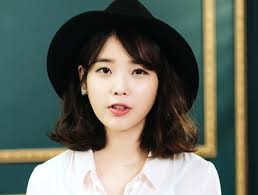

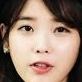

In [138]:
from IPython.display import Image
display(Image('Images/iu_10.jpg'))
display(Image('Images_crop/iu/iu_10.jpg'))

In [98]:
# Get Image names for testing
test_image_path_names=[]
for file_name in glob.glob(path+'/Test_images/*_*.jpg'):
  test_image_path_names.append(file_name)

In [99]:
len(test_image_path_names)

20

## Test_Image 파일들 crop

Test_Images의 파일들을 읽어 Test_Images_crop에 생성

In [153]:
os.mkdir(path+'/Test_Images_crop/')

In [154]:
# Create Separate folder for each person in "Test_Images_crop" folder
for person in person_names:
  os.mkdir(path+'/Test_Images_crop/'+person+'/')

In [155]:
# Detect face,crop face and save in corresponding folder
for file_name in test_image_path_names:
  img=cv2.imread(file_name)
  gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  rects=dnnFaceDetector(gray,1)
  left,top,right,bottom=0,0,0,0
  for (i,rect) in enumerate(rects):
    left=rect.rect.left() #x1
    top=rect.rect.top() #y1
    right=rect.rect.right() #x2
    bottom=rect.rect.bottom() #y2
  if right==0: continue
  width=right-left
  height=bottom-top
  img_crop=img[top:top+height,left:left+width]
  img_path=path+'/Test_Images_crop/'+file_name.split('/')[-1].split('_')[0]+'/'+file_name.split('/')[-1]
  cv2.imwrite(img_path,img_crop)

<pre>Here images are sorted to corresponding test and train folders of same person
Directory structure :
|Images /
|  |-- (60 images)
|Images_crop /
|  |--faker
|     |--(images)
|  |--iu / 
|     |--(images)
|  |--jobs / 
|     |--(imgaes)
|Test_Images / 
|  |-- .. / (18 images)
|Test_Images_crop / 
|  |--faker
|     |--(images)
|  |--iu / 
|     |--(images)
|  |--jobs / 
|     |--(imgaes)
|mmod_human_face_detector.dat
</pre>

# VGG Face Model 다운로드

In [139]:
! pip install gdown

In [140]:
#Download pre-trained vgg-face-model-weights as .h5 file
! gdown https://drive.google.com/uc?id=1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo

Downloading...
From: https://drive.google.com/uc?id=1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo
To: /content/face_data/vgg_face_weights.h5
580MB [00:12, 47.3MB/s]


In [141]:
%ls -al

total 567912
drwxr-xr-x 5 root root      4096 Jun 22 11:24 ./
drwxr-xr-x 1 root root      4096 Jun 22 11:14 ../
drwxr-xr-x 2 root root      4096 Jun 22 10:47 Images/
drwxr-xr-x 5 root root      4096 Jun 22 11:16 Images_crop/
-rw-r--r-- 1 root root    729940 Oct  8  2016 mmod_human_face_detector.dat
-rw-r--r-- 1 root root    694709 Oct  8  2016 mmod_human_face_detector.dat.bz2.1
drwxr-xr-x 2 root root      4096 Jun 22 10:47 Test_images/
-rw-r--r-- 1 root root 580085408 Jun 22 11:24 vgg_face_weights.h5


In [142]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D
from tensorflow.keras.layers import Dense,Dropout,Softmax,Flatten,Activation,BatchNormalization
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import tensorflow.keras.backend as K

In [143]:
#Define VGG_FACE_MODEL architecture
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [144]:
# Load VGG Face model weights
model.load_weights('vgg_face_weights.h5')

In [145]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

In [146]:
# Remove Last Softmax layer and get model upto last flatten layer with outputs 2622 units
vgg_face=Model(inputs=model.layers[0].input,outputs=model.layers[-2].output)

# 학습 모델 준비

In [147]:
#Prepare Training Data
x_train=[]
y_train=[]
person_folders=os.listdir(path+'/Images_crop/')
person_rep=dict()
for i,person in enumerate(person_folders):
  person_rep[i]=person
  image_names=os.listdir('Images_crop/'+person+'/')
  for image_name in image_names:
    img=load_img(path+'/Images_crop/'+person+'/'+image_name,target_size=(224,224))
    img=img_to_array(img)
    img=np.expand_dims(img,axis=0)
    img=preprocess_input(img)
    img_encode=vgg_face(img)
    x_train.append(np.squeeze(K.eval(img_encode)).tolist())
    y_train.append(i)

In [148]:
person_rep

{0: 'iu', 1: 'jobs', 2: 'faker'}

In [149]:
x_train=np.array(x_train)
y_train=np.array(y_train)

In [156]:
#Prepare Test Data
x_test=[]
y_test=[]
person_folders=os.listdir(path+'/Test_Images_crop/')
for i,person in enumerate(person_folders):
  image_names=os.listdir('Test_Images_crop/'+person+'/')
  for image_name in image_names:
    img=load_img(path+'/Test_Images_crop/'+person+'/'+image_name,target_size=(224,224))
    img=img_to_array(img)
    img=np.expand_dims(img,axis=0)
    img=preprocess_input(img)
    img_encode=vgg_face(img)
    x_test.append(np.squeeze(K.eval(img_encode)).tolist())
    y_test.append(i)

In [157]:
x_test=np.array(x_test)
y_test=np.array(y_test)

In [158]:
# Save test and train data for later use
np.save('train_data',x_train)
np.save('train_labels',y_train)
np.save('test_data',x_test)
np.save('test_labels',y_test)

In [159]:
# Load saved data
x_train=np.load('train_data.npy')
y_train=np.load('train_labels.npy')
x_test=np.load('test_data.npy')
y_test=np.load('test_labels.npy')

# 모델 정의

In [160]:
# Softmax regressor to classify images based on encoding 
classifier_model=Sequential()
classifier_model.add(Dense(units=100,input_dim=x_train.shape[1],kernel_initializer='glorot_uniform'))
classifier_model.add(BatchNormalization())
classifier_model.add(Activation('tanh'))
classifier_model.add(Dropout(0.3))
classifier_model.add(Dense(units=10,kernel_initializer='glorot_uniform'))
classifier_model.add(BatchNormalization())
classifier_model.add(Activation('tanh'))
classifier_model.add(Dropout(0.2))
classifier_model.add(Dense(units=6,kernel_initializer='he_uniform'))
classifier_model.add(Activation('softmax'))
classifier_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer='nadam',metrics=['accuracy'])

# 모델 학습

In [161]:
classifier_model.fit(x_train,y_train,epochs=100,validation_data=(x_test,y_test))

Train on 39 samples, validate on 20 samples
Epoch 1/100
39/39 [==============================] - 1s 29ms/sample - loss: 2.3741 - acc: 0.0513 - val_loss: 0.7293 - val_acc: 0.7000
Epoch 2/100
39/39 [==============================] - 0s 577us/sample - loss: 0.8959 - acc: 0.6667 - val_loss: 0.6771 - val_acc: 0.6500
Epoch 3/100
39/39 [==============================] - 0s 575us/sample - loss: 0.7025 - acc: 0.7436 - val_loss: 0.7016 - val_acc: 0.8500
Epoch 4/100
39/39 [==============================] - 0s 546us/sample - loss: 0.7728 - acc: 0.9231 - val_loss: 0.8100 - val_acc: 0.7000
Epoch 5/100
39/39 [==============================] - 0s 599us/sample - loss: 0.7882 - acc: 0.8205 - val_loss: 0.6776 - val_acc: 0.7500
Epoch 6/100
39/39 [==============================] - 0s 578us/sample - loss: 0.5985 - acc: 0.9231 - val_loss: 0.6629 - val_acc: 0.7500
Epoch 7/100
39/39 [==============================] - 0s 711us/sample - loss: 0.5260 - acc: 0.9231 - val_loss: 0.5666 - val_acc: 0.9500
Epoch 8/100


In [165]:
# Save model for later use
tf.keras.models.save_model(classifier_model,'face_classifier_model.h5')

In [166]:
# Load saved model
classifier_model=tf.keras.models.load_model('face_classifier_model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [167]:
# Path to folder which contains images to be tested and predicted
test_images_path=path+'/Test_Images/'

In [168]:
dnnFaceDetector=dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")

# 얼굴 인식 실행

In [169]:
def plot(img):
  plt.figure(figsize=(8,4))
  plt.imshow(img[:,:,::-1])
  plt.show()

In [170]:
# Label names for class numbers
person_rep={0: 'iu', 1: 'jobs', 2: 'faker'}

In [171]:
os.mkdir(path+'/Predictions')

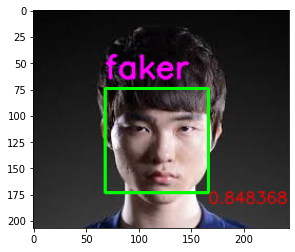

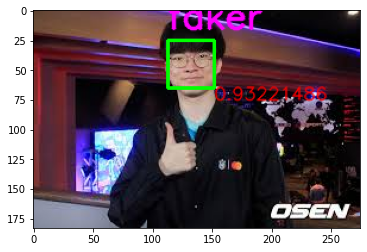

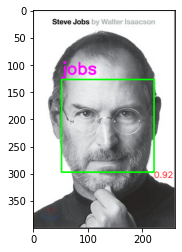

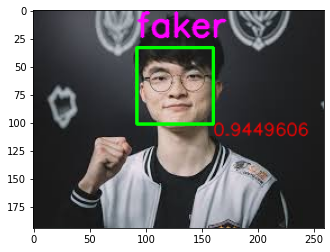

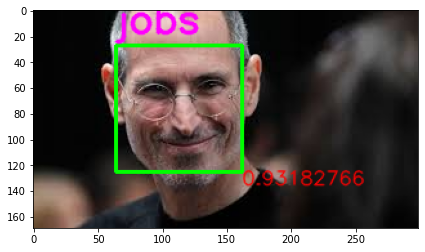

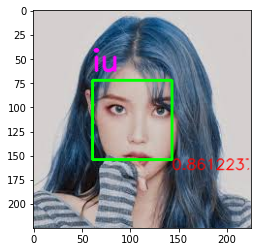

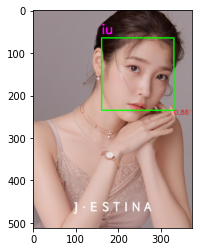

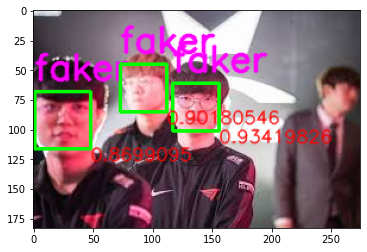

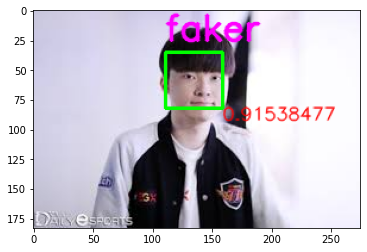

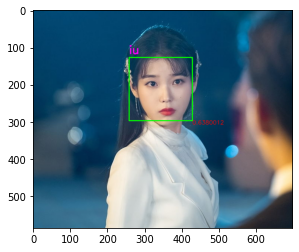

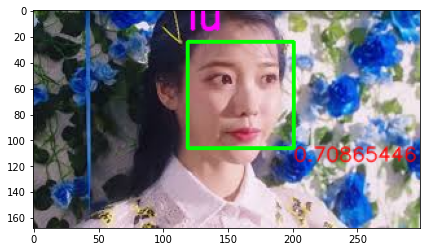

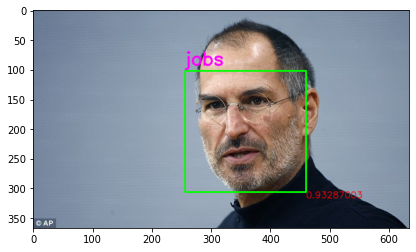

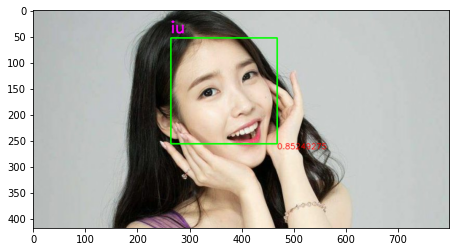

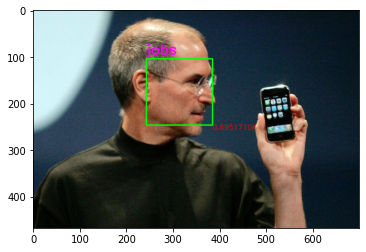

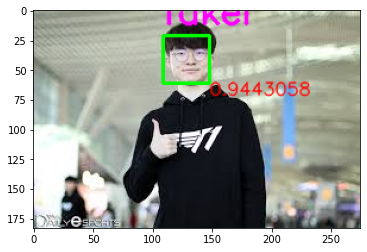

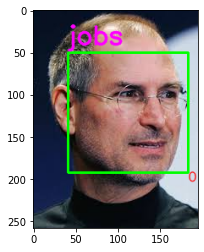

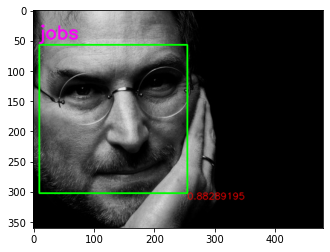

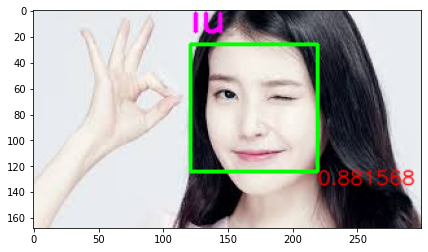

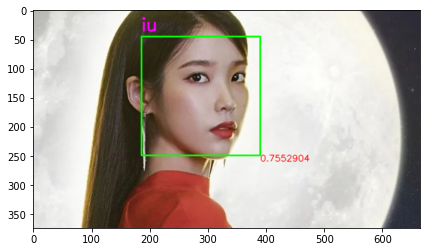

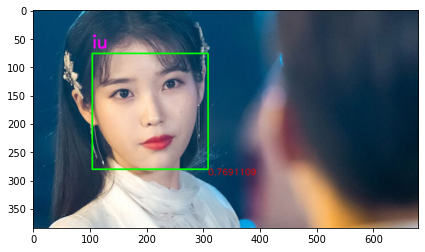

In [175]:
for img_name in os.listdir(path+'/Test_images/'):
  if img_name=='crop_img.jpg':
    continue
  # Load Image
  img=cv2.imread(path+'/Test_images/'+img_name)
  gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # 얼굴 탐지
  rects=dnnFaceDetector(gray,1)
  left,top,right,bottom=0,0,0,0
  for (i,rect) in enumerate(rects):
    # Extract Each Face
    left=rect.rect.left() #x1
    top=rect.rect.top() #y1
    right=rect.rect.right() #x2
    bottom=rect.rect.bottom() #y2
    width=right-left
    height=bottom-top
    img_crop=img[top:top+height,left:left+width]
    cv2.imwrite(path+'/Test_images/crop_img.jpg',img_crop)
    
    # 얼굴 영역 crop
    crop_img=load_img(path+'/Test_images/crop_img.jpg',target_size=(224,224))
    crop_img=img_to_array(crop_img)
    crop_img=np.expand_dims(crop_img,axis=0)
    crop_img=preprocess_input(crop_img)
    img_encode=vgg_face(crop_img)

    # 얼굴 영역 인식
    embed=K.eval(img_encode)
    person=classifier_model.predict(embed)
    name=person_rep[np.argmax(person)]
    os.remove(path+'/Test_images/crop_img.jpg')
    cv2.rectangle(img,(left,top),(right,bottom),(0,255,0), 2)
    img=cv2.putText(img,name,(left,top-10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,255),2,cv2.LINE_AA)
    img=cv2.putText(img,str(np.max(person)),(right,bottom+10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)
  # Save images with bounding box,name and accuracy 
  cv2.imwrite(path+'/Predictions/'+img_name,img)
  plot(img)